# Adversarial starts below

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np 
import time 
import scipy
from keras import Sequential
from keras import Model
from google.colab.patches import cv2_imshow

num_classes = 1000
input_shape = (28, 28, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
X_train = np.stack([x_train, x_train, x_train], axis=-1)
X_test = np.stack([x_test, x_test, x_test], axis=-1)
Y_train = keras.utils.to_categorical(y_train,1000)
Y_test = keras.utils.to_categorical(y_test,1000)

In [ ]:
input_mask = np.pad(np.zeros([1, 28, 28, 3]),
                            [[0,0], [136, 135], [136, 135], [0,0]],
                            'constant', constant_values = 1)
input_mask.shape

(1, 299, 299, 3)

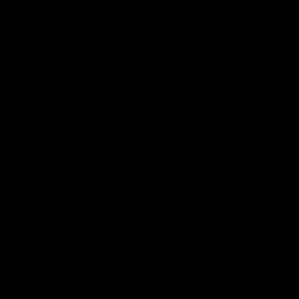

In [ ]:
cv2_imshow(input_mask[0])

In [ ]:
import keras.backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
from keras import initializers,regularizers
from keras.optimizers import *
from keras.callbacks import *

M = np.ones((299,299,3)).astype('float32')
M[135:163,135:163,:] = 0

class AdvLayer(Layer):
    def __init__(self, W_regularizer=0.05, **kwargs):
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.l2(W_regularizer)
        super(AdvLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        assert len(input_shape) == 4
        self.W = self.add_weight(name='kernel', 
                                      shape=(299,299,3),
                                      initializer=self.init, regularizer=self.W_regularizer,
                                      trainable=True)
        super(AdvLayer, self).build(input_shape)
    def call(self, x):
        prog = K.tanh(self.W*M)
        out = x + prog
        return out
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],input_shape[3])

In [ ]:
basemodel = tf.keras.applications.InceptionV3(weights="imagenet")
x = Input(shape=input_shape)
x_aug = ZeroPadding2D(padding=((135,136),(135,136)))(x)
out = AdvLayer()(x_aug)
probs = basemodel(out)
model = Model(inputs=x,outputs=probs)
model.layers[-1].trainable = False
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("advweightsinception.h5",save_freq='epoch', save_best_only = True, monitor='loss',
                            save_weights_only=True, mode='min', verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, min_lr=0.000001, mode='auto')
stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode= 'min')
history = model.fit(X_train,Y_train,epochs = 100,batch_size=32, validation_data = (X_test,Y_test), verbose=1, callbacks=[checkpoint,reduce_lr,stopping])